<a href="https://colab.research.google.com/github/VMBoehm/ML_Lectures/blob/main/IntroductionToVariationalAutoencoders_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Introduction to Variational AutoEncoders (VAEs) and applications to physical data** 

by Vanessa Boehm (UC Berkeley and LBNL)   
Feb 27 2022


---


In this notebook we will be implementing our first Variational Autoencoder. VAEs are a useful tool for the analysis of physical data because of their probabilistic layout.   

We will start from a (non-probalistic) autoencoder and convert it into its variational counterpart.

## Autoencoder

Recall that an Auto-Encoder consists of two networks: 

1.   An encoder network that takes the data, $x$, and maps it to a lower-dimensional latent space. We will call this network $f$ and its network parameters $\phi$.
2.   A decoder network that takes the encoded data, $z$, and maps it back to the data space. We will call the result of the reconstruction $x'$, the decoder network $g$ (for generator) and its network parameters $\psi$.

$$ x' = g_\psi(f_\phi(x)) \tag{1}$$

An Auto-Encoder is trained to minimize the reconstruction error between the input $x$ and the reconstruction $x'$.

$$ \mathcal{L}_{AE}(\phi,\psi) = ||x-g_\psi(f_\phi(x))||^2_2 \tag{2}$$

---

## Probabilistic Interpretation (lecture recap)

**In a Variational Auto-Encoder we interpret the reconstruction task  probabilistically:**

Compressing the data results in a loss of information about the original data. 
If we only have access to the compressed data, we have no chance of knowing what the original data looked like *exactly*. Instead, we obtain a probability distribution over possible inputs.

$$ p(x) = \int \mathrm{d}z\, p(x|z) p(z) \tag{3}$$

Here, we have introduced two probability distributions on the right hand side, the liklelihood, $p(x|z)$, and the prior, $p(z)$.

The likelihood arises because of the information loss in the compression.

$$ x = g_\psi(f_\phi(x)) + \epsilon = g_\psi(z) + \epsilon \tag{4}$$ 

Ideally, $\epsilon$, the part of the data that is lost in the compression, is just noise and unimportant for our final data analysis. The form of the likelihood is equal to the distribution of this noise. For example, if the noise is Gaussian (which is often the case for physical data) with covariance $\Sigma_\epsilon$, the likelihood is a Gaussian distribution:

$$ p_{\psi}(x|z) = \mathcal{G}(g_\psi(z),\Sigma_\epsilon) \tag{5}$$ 

**Optional Question 1**   
Starting from $p(x|z) = \int \mathrm{d}\epsilon\, p(x,\epsilon|z)$ can you show that the likelihood follows the same distribution as $\epsilon$?

Solution:
$p(x|z) = \int \mathrm{d}\epsilon\, p(x,\epsilon|z) = \int \mathrm{d}\epsilon\, p(x|z,\epsilon) p(\epsilon) = \int \mathrm{d}\epsilon\, \delta_D(x-g(z)-\epsilon) p(\epsilon) = p(x-g(z))$ 

The prior, $p(z)$, is the average distribution of the encoded data.

$$ p(z) = \int \mathcal{d}x\, p(z|x) p(x) \tag{6}$$

In a VAE, we want the prior distribution to have closed form and to be easy to sample from (for artificial data generation). We have the freedom to choose the prior distribution as a constraint. The network training will ensure it is obeyed. A common choice is a normal distribution

$$ p(z) = \mathcal{N}(0,1) \tag{7} $$

---

### VAE training & Evidence Lower BOund (ELBO)

To train the Variational Auto-Encoder we maximize the average log probability, $\log p(x)$, or, as we will see now, a lower bound to this quantity.

Equation (3) involves solving a fairly high dimensional integral, which is a computationally expensive and sometimes infeasible operation. This integral has to be solved not only once, but in each training step. Variational Autoencoders  solve this integral approximately by using a variational ansatz for the posterior distribution, the approximate posterior $q_\phi(z|x)$. This distribution approximates the true posterior p(z|x) and is parameterized by the encoder parameters $\phi$. 

The classic choice for the variational posterior is a multivariate Gaussian in the mean field approxiation (mean field meaning no off-diagonal terms in the covariance)

$$ q_\phi(z|x) = \mathcal{G}(\mu,\sigma_i) \tag{7} $$

where the mean, $\mu$, and variance, $\sigma$, are determined by the encoder network. 

$$(\mu, \sigma) = f_\phi(x) \tag{8} $$

As we saw in the lecture, the variational ansatz allows us to formulate a lower bound to $\log p(x)$, the Evidence Lower BOund.

$$ \log p(x) >= \int \mathrm{d}z\, q_\phi(z|x) \log{p_\psi(x|z)} - \int \mathrm{d}z\, q_\phi(z|x) \log{\frac{q_\phi(z|x)}{p(z)}} = ELBO \tag{8}$$

$$ \mathcal{L}_{VAE}(\phi,\psi) = -ELBO \tag{9}$$

The ELBO consists of two terms. The first term measures the expectation value of the likelihood over the posterior. Maximizing this term encourages high quality reconstructions (similar to the autoencoder). The second term is the KL-Divergence (a distance measure) between the variational posterior and the prior. This term acts as a regularizer. It encourages posterior distributions which are similar to the prior.

In VAE training the first term is evaluated stochastically, meaning that the expectation value is evaluated approximately by averaging over a number of samples from $q_\phi(z|x)$. The second term can be either evaluated analytically (the KL divergence between to Gaussian distributions can be calculated) or stochastically. 

---

### Reparametrization Trick

Minimizing Eq. (9) requires taking gradients with respect to $\phi$ and $\psi$. But how do we take the gradient through an expectation value?  

We use what is called the reparametrization trick. Instead of sampling from the posterior $q_\phi(z|x)$ we sample from the parameter-independent normal distribution

$$ \zeta ∼ \mathcal{N}(0,1) \tag{10}$$

and use the identity $z=\zeta*\sigma_\phi+\mu_\phi$, an operation which is trivially differentiably, to obtain our samples.

Pytorch will perform the reparametrization trick for us under the hood, if we use *distribution.rsample()* - so we don't have to code it explicitly.


Let' start by importing a few packages, that we will need later

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

### Our dataset

In this coding exercise we will be working with a galaxy spectra sample from the SDSS-BOSS DR 16 release. The spectra have been de-redshifted to the restframe and their magnitude has been standardized to a distance correspondingg to $z_\lambda=0.01$. They have further been downsampled to 1000 pixels, denoised and inpainted where masks were present.

(I can tell you more about the data cuts and preprocessing if you are interested, but it is not relevant for this task.)

Despite being relatively high-dimensional ($d=1000$), galaxy specrtra actually reside on a lower dimensional manifold since we can compress them to much smaller dimensionality without sacrificing much reconstruction quality. 

This property makes them a very suitable data type for VAEs. 

(The same applies to image data, but images datasets are computationally more expensive to train on and they need more complicated nework architectures - things that we don't want to worry about in this exercise.)

STEP 1: Download the training and test datasets 

1.   [training set](https://drive.google.com/file/d/1oGe1zsgyCEBY1N_t-GkxxoSgVnJyTms2/view?usp=sharing)
2.   [test set](https://drive.google.com/file/d/1wXtOpUKGj2gMff2KbBfY4x8HnzxguyXJ/view?usp=sharing)

and place them in your Google Drive. (If you want to avoid having to modify the file paths in the code below, you need to create a folder called 'ML_lecture_data' and place the files in there.)


Next, we link Google Drive to this notebook

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Use this line to check the location of your files

In [ ]:
! ls drive/MyDrive/ML_lecture_data/

DR16_denoised_inpainted.npy	  DR16_denoised_inpainted_train.npy
DR16_denoised_inpainted_test.npy


Let's set some immutable variables:
The dimensionality of the input data and the dimensionality of the latent (encoded) space

In [ ]:
INPUT_SIZE      = 1000
LATENT_SIZE     = 2

Next we create pytorch datasets from the training and test data (note that you need to change the root_dir, if you placed the data in a different folder)

In [ ]:
class SDSS_DR16(Dataset):
    """De-redshifted and downsampled spectra from SDSS-BOSS DR16"""

    def __init__(self, root_dir='drive/MyDrive/ML_lecture_data/', transform=True, train=True):
        """
        Args:
            root_dir (string): Directory of data file
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        if train:
            self.data = np.load(open(os.path.join(root_dir,'DR16_denoised_inpainted_train.npy'),'rb'),allow_pickle=True)
        else:
            self.data = np.load(open(os.path.join(root_dir,'DR16_denoised_inpainted_test.npy'),'rb'),allow_pickle=True)

        self.data = torch.as_tensor(self.data)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data[idx]

        return sample




training_data = SDSS_DR16(train=True)
test_data     = SDSS_DR16(train=False)

Next we define our encoder and decoder networks. We use a very simple MLP, with two linear layers and one non-linear activation function. 

In [ ]:
class Encoder(nn.Module):

    def __init__(self, seed=853):
        super(Encoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(INPUT_SIZE,50)
        self.fc2 = nn.Linear(50,LATENT_SIZE)

    # this defines a forward pass of the network (="applying" the network to some input data)
    def forward(self, x):
        x      = torch.nn.LeakyReLU()(self.fc1(x))
        z      = self.fc2(x)
        return z

class Decoder(nn.Module):

    def __init__(self, seed=620):
        super(Decoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(LATENT_SIZE,50)
        self.fc2 = nn.Linear(50,INPUT_SIZE)


    def forward(self, z):
        z = torch.nn.LeakyReLU()(self.fc1(z))
        x = self.fc2(z)
        return x

Having defined the encoder and decoder network, we can move on to define the Autoencoder.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # here we are creatin instances of the Encoder and Decoder class
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

In [ ]:
# This creates an instance of the Autoencoder class
AE = Autoencoder()

Now that we have defined our model, the next step is to train it. This is what a generic training loop looks like:

In [ ]:
# the training loop takes a function that loads the data, batch by batch, a model to train, a loss function to train the model on and an optimizer
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    # iterate over the dataset
    for batch, X in enumerate(dataloader):
        # Compute prediction of the model (in case of the AE the prediction is the reconstructed data)
        pred = model(X)
        # Compute the loss function (in case of the AE this is the L2 distance to the input data)
        loss = loss_fn(pred,X)

        # Backpropagation; this is where we take the gradient and update the network parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # here we keep track of the loss
        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            losses.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    return losses


# the test loop is similar to the training loop, only that we don't take any gradients/don't update the network parameters, but only evaluate
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss =  0

    with torch.no_grad():
        for X in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, X).item()

    test_loss /= num_batches
    print(f" Avg loss: {test_loss:>8f} \n")

    return test_loss


In the next cell we set the training parameters, define the loss function and create DataLoaders. Pytorch DataLoaders manage the data loading for us (break the dataset into batches, keep track of epochs, reshuffle the data after each epoch) 

In [ ]:
BATCHSIZE       = 128
BATCHSIZE_TEST  = 256
LEARNING_RATE   = 1e-3

# MeanSquaredError (L2) Loss
loss_fn         = nn.MSELoss()
# Adam Optimizer
optimizer       = torch.optim.Adam(AE.parameters(), lr=LEARNING_RATE)

# Dataloaders
train_dataloader = DataLoader(training_data, batch_size=BATCHSIZE, shuffle=True)
test_dataloader  = DataLoader(test_data, batch_size=BATCHSIZE_TEST, shuffle=True)

It's finally time for training:

In [ ]:
EPOCHS = 10

train_loss = []
test_loss  = []
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_loop(train_dataloader, AE, loss_fn, optimizer))
    test_loss.append(test_loop(test_dataloader, AE, loss_fn))
print("Done!")

Epoch 1
-------------------------------
loss: 1.897722  [    0/100000]
loss: 0.014158  [64000/100000]
 Avg loss: 0.019276 

Epoch 2
-------------------------------
loss: 0.038577  [    0/100000]
loss: 0.005085  [64000/100000]
 Avg loss: 0.031908 

Epoch 3
-------------------------------
loss: 0.023836  [    0/100000]
loss: 0.009034  [64000/100000]
 Avg loss: 0.021726 

Epoch 4
-------------------------------
loss: 0.042028  [    0/100000]
loss: 0.012721  [64000/100000]
 Avg loss: 0.019283 

Epoch 5
-------------------------------
loss: 0.005000  [    0/100000]
loss: 0.018683  [64000/100000]
 Avg loss: 0.015865 

Epoch 6
-------------------------------
loss: 0.019513  [    0/100000]
loss: 0.003738  [64000/100000]
 Avg loss: 0.015180 

Epoch 7
-------------------------------
loss: 0.022637  [    0/100000]
loss: 0.022227  [64000/100000]
 Avg loss: 0.023163 

Epoch 8
-------------------------------
loss: 0.018685  [    0/100000]
loss: 0.015868  [64000/100000]
 Avg loss: 0.014543 

Epoch 9


Let's see how the model is doing. Let's look at 

1.   Training and test loss 
2.   Final reconstruction quality

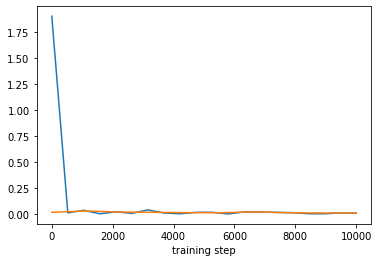

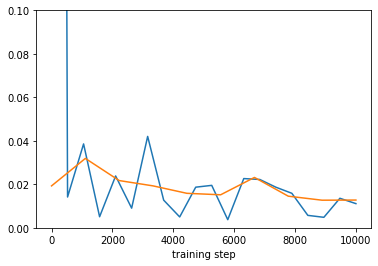

In [ ]:
# losses
length = len(np.asarray(train_loss).flatten())
plt.figure()
plt.plot(np.linspace(0,length*500,length), np.asarray(train_loss).flatten())
plt.plot(np.linspace(0,length*500,len(test_loss)),test_loss)
plt.xlabel('training step')
plt.show()

### zoom in 
length = len(np.asarray(train_loss).flatten())
plt.figure()
plt.plot(np.linspace(0,length*500,length), np.asarray(train_loss).flatten())
plt.plot(np.linspace(0,length*500,len(test_loss)),test_loss)
plt.xlabel('training step')
plt.ylim(0,0.1)
plt.show()

You can see that the model had a really easy time learning the tak and that we haven't overfitted yet

Now, let's look at the reconstructions:

### ***Variational Autoencoder***

In [ ]:
class Encoder(nn.Module):

    def __init__(self, seed=853):
        super(Encoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(INPUT_SIZE,50)
        self.fc2 = nn.Linear(50,LATENT_SIZE*2)

    def forward(self, x):
        x      = torch.nn.LeakyReLU()(self.fc1(x))
        x      = self.fc2(x)
        z, std = torch.split(x, 2,dim=1)
        std    = torch.exp(std) + 1e-8
        return z, std

class Decoder(nn.Module):

    def __init__(self, seed=620):
        super(Decoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(LATENT_SIZE,50)
        self.fc2 = nn.Linear(50,INPUT_SIZE)

    def forward(self, z):
        z = torch.nn.LeakyReLU()(self.fc1(z))
        x = self.fc2(z)
        return x

In [ ]:
# https://pytorch.org/docs/stable/distributions.html#normal
from torch.distributions import Normal as Normal 

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, sample_size, sigma):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.sample_size = sample_size
        self.sigma       = sigma
        self.prior       = Normal(torch.zeros(LATENT_SIZE), torch.ones(LATENT_SIZE))

    def get_log_likelihood(self,recons,x):
        ll = Normal(x, self.sigma)
        log_p = torch.sum(ll.log_prob(recons),dim=-1)
        return torch.mean(log_p,dim=0)

    def get_q(self,x):
        mu, std = self.encoder(x)
        self.q = Normal(mu, std)
        return True

    def sample_q(self):
        z_sample = self.q.rsample(torch.Size([self.sample_size]))

        return z_sample

    def stochastic_kl_divergence(self,z_sample):
        
        return torch.mean(torch.sum(self.q.log_prob(z_sample),dim=-1)-torch.sum(self.prior.log_prob(z_sample),dim=-1), dim=0)

    def forward(self, x):

        self.get_q(x)
        samples = self.sample_q()
        recons  = self.decoder(samples)
        log_likelihood = self.get_log_likelihood(recons,x)
        kl      = self.stochastic_kl_divergence(samples)
        return log_likelihood, kl

In [ ]:
VAE = VariationalAutoencoder(16,sigma=0.05)

optimizer = torch.optim.Adam(VAE.parameters(), lr=LEARNING_RATE)

In [ ]:
def negative_ELBO(avg_log_likelihood,kl):

    negative_ELBO = - torch.mean(avg_log_likelihood-kl)

    return negative_ELBO

In [ ]:


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    for batch, X in enumerate(dataloader):
        # Compute prediction and loss
        log_likelihood, kl = model(X)
        loss = loss_fn(log_likelihood,kl)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            losses.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    return losses


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, log_likelihood, nkl, recon_error = 0, 0, 0, 0

    with torch.no_grad():
        for X in dataloader:
            log_likelihood, kl = model(X)
            recon              = model.decoder(model.encoder(X)[0])
            test_loss += loss_fn(log_likelihood,kl).item()
            test_loss += loss_fn(log_likelihood,kl).item()

    test_loss /= num_batches
    print(f" Avg loss: {test_loss:>8f} \n")

    return test_loss


In [ ]:
epochs = 10

train_loss = []
test_loss  = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_loop(train_dataloader, VAE, negative_ELBO, optimizer))
    test_loss.append(test_loop(valid_dataloader, VAE, negative_ELBO))
print("Done!")

Epoch 1
-------------------------------
loss: 653572.750000  [    0/80000]
loss: -279.123627  [64000/80000]
 Avg loss: 3836.217502 

Epoch 2
-------------------------------
loss: 599.784119  [    0/80000]
loss: -582.502808  [64000/80000]
 Avg loss: 3024.402248 

Epoch 3
-------------------------------
loss: 3045.066895  [    0/80000]
loss: -292.454681  [64000/80000]
 Avg loss: 2354.063658 

Epoch 4
-------------------------------
loss: 4205.329590  [    0/80000]
loss: 23452.093750  [64000/80000]
 Avg loss: 4062.760802 

Epoch 5
-------------------------------
loss: 6039.985352  [    0/80000]
loss: 6312.842773  [64000/80000]
 Avg loss: 1920.672691 

Epoch 6
-------------------------------
loss: 6556.687500  [    0/80000]
loss: 316.593414  [64000/80000]
 Avg loss: 1728.253586 

Epoch 7
-------------------------------
loss: 1260.603882  [    0/80000]
loss: -1033.803345  [64000/80000]
 Avg loss: 1708.271723 

Epoch 8
-------------------------------
loss: 642.583252  [    0/80000]
loss: 293

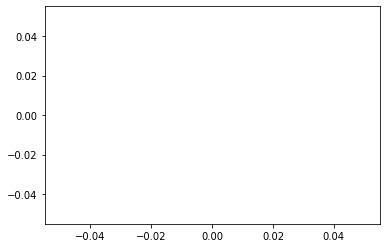

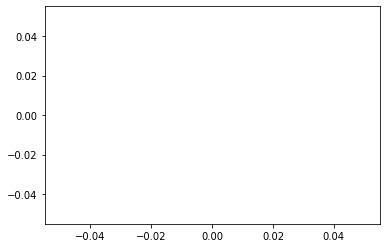

In [ ]:
plt.figure()
plt.plot(np.asarray(train_loss).flatten())
plt.show()

plt.plot(np.linspace(0,len(np.asarray(train_loss).flatten()),len(test_loss)),test_loss)
#plt.ylim(0,0.1)
plt.show()